In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os
import json
from collections import OrderedDict

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py
import dill
from tqdm import tqdm
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.interpolate import interp1d


In [3]:
from agnfinder.prospector import main, load_photometry
from agnfinder import photometry_to_table
from agnfinder.tf_sampling import deep_emulator

In [4]:
os.chdir('/home/walml/repos/agnfinder')

In [5]:
DATA_ROOT = '/home/walml/repos/agnfinder/data'

We'll construct a catalog with magnitudes (and errors) like the catalog loaded here

In [6]:
parquet_loc = os.path.join(DATA_ROOT, 'photometry_quicksave.parquet')  # should be df with loaded photometry in maggies

In [7]:
df = pd.read_parquet(parquet_loc)

In [8]:
bands = df.columns.values[:12]
errors = df.columns.values[12:]
# 11 bands, hardcoded for now
bands, errors

(array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
       dtype=object),
 array(['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err', 'VISTA_Ks_err',
        'VISTA_Y_err', 'VISTA_Z_err', 'wise_w1_err', 'wise_w2_err'],
       dtype=object))

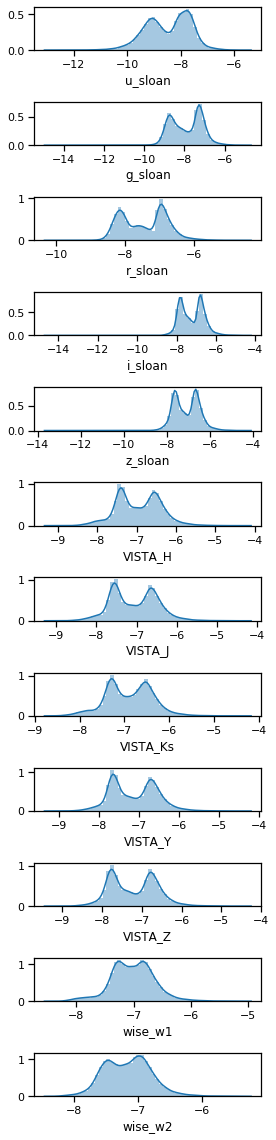

In [9]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(np.log10(df[band]), ax=ax)
fig.tight_layout()

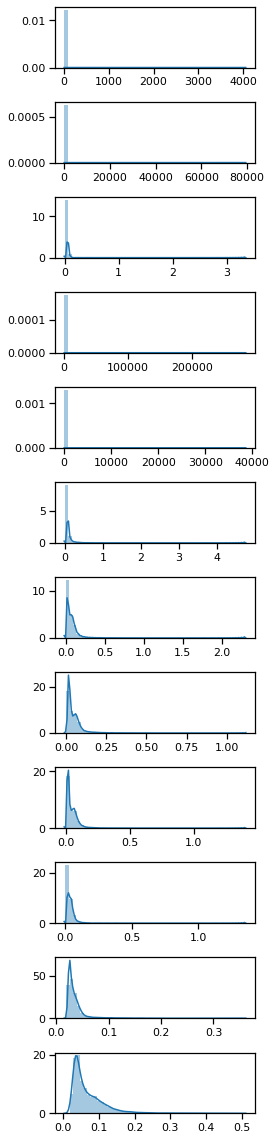

In [10]:
# bimodal because of the high-z QSO, presumably
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    sns.distplot(df[errors[n]]/df[band], ax=ax)
fig.tight_layout()

Let's do the same but now recording the distributions, rather than automatically with seaborn

In [11]:
from scipy.stats import gaussian_kde

In [12]:
kdes = {}
for band in bands:
    kdes[band] = gaussian_kde(np.log10(df[band]))

In [13]:
with open(os.path.join(DATA_ROOT, 'cpz_maggie_kdes.pickle'), 'wb') as f:
    dill.dump(kdes, f)

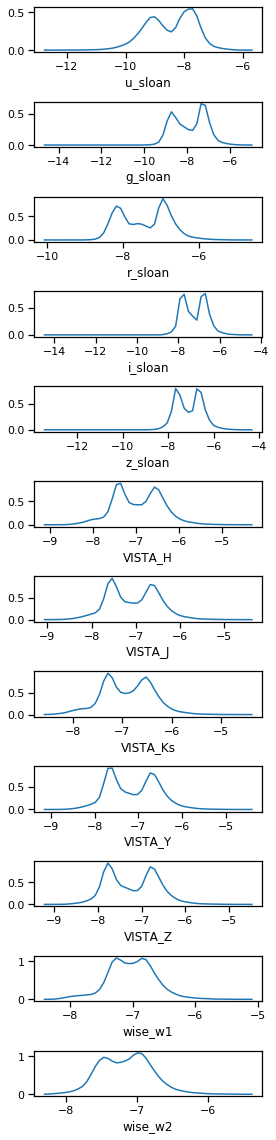

In [14]:
fig, axes = plt.subplots(nrows=len(bands), figsize=(4, 16))
for n, band in enumerate(bands):
    ax = axes[n]
    x = np.linspace(np.log10(df[band].min()), np.log10(df[band].max()))
    ax.plot(x, kdes[band](x))
    ax.set_xlabel(band)
fig.tight_layout()

Great. Let's test that we can sample a non-random grid using pairwise matching

- draw a set of maggies from the kdes above (all bands)
- find the galaxy in the cube with the most similar maggies (code already exists)
- select that galaxy (and do not select again)

These cube galaxies will have different underlying parameters (we can't know these for real galaxies) but will be observationally identical

But hmm - the bands are highly dependent on each other (see notes).
Sampling from marginals != sampling from joint!

Instead, let's be simple:
- pick a real galaxy
- find the synthetic pair, do not pick again

In [15]:
cube_dir = 'data/cubes/latest'

In [16]:
_, _, x_test, y_test = deep_emulator.data(cube_dir, rescale=False)

In [17]:
x_test.shape, y_test.shape

((60000, 9), (60000, 8))

In [18]:
bands

array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
      dtype=object)

In [19]:
euclid_bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']

In [20]:
output_dim = 8
n_galaxies = 1000


Convert the whole thing to a function

In [21]:
def find_closest_galaxies(input_rows: np.array, candidates: np.array, duplicates: bool):
    pairs = []
    used_indices = set()
    for n, photometry in tqdm(enumerate(input_rows), total=len(input_rows)):
        error = np.sum((photometry - candidates) ** 2, axis=1)
        lowest_k_indices = np.argpartition(error, len(input_rows))  # find the lowest (catalog n) rows, don't bother sorting the rest
        lowest_k = error[lowest_k_indices]
        sorted_lowest_k_indices = np.argsort(lowest_k) # indices to sort the lowest k rows, *indexed only to the lowest k*
        sorted_indices = lowest_k_indices[sorted_lowest_k_indices]
        for index in sorted_indices:
            if index in used_indices:
                pass
            else: # use
                pairs.append(index)
                if duplicates is False:  # don't re-use
                    used_indices.add(index)  
                break
        if index == sorted_indices[-1]:
            raise ValueError('No match found, should be impossible?')
            
    return pairs


def select_subsample(photometry_df: pd.DataFrame, cube_y: np.array, duplicates=False):
    
    bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
       'VISTA_J', 'VISTA_Y']  # euclid
    assert cube_y.shape[1] == len(bands)
    
    # trim real photometry outliers
    limits = {}
    for band in bands:
        limits[band] = (np.percentile(photometry_df[band], 2), np.percentile(photometry_df[band], 98))
    df_clipped = photometry_df.copy()
    for band in bands:
        lower_lim = limits[band][0]
        upper_lim = limits[band][1]
        df_clipped = photometry_df.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}').reset_index()  # new index ONLY matches this new df, don't apply to old df

    all_photometry = -np.log10([row for _, row in df_clipped[bands].iterrows()])
    
    pairs = find_closest_galaxies(all_photometry, cube_y, duplicates=duplicates)
    return df_clipped, pairs



In [22]:
assert False

AssertionError: 

In [ ]:
df_clipped, pairs = select_subsample(df, y_test)

In [ ]:
len(pairs), len(df_clipped), len(df)

In [ ]:
df_clipped.iloc[pairs[0]]

In [ ]:
pd.value_counts(pairs)

In [36]:
x_test = np.loadtxt('data/cubes/x_matched_unfiltered.npy')
y_test = np.loadtxt('data/cubes/y_matched_unfiltered.npy')

In [37]:
y_test.sum(axis=1)

array([56.73948686, 55.0585303 , 57.73773017, ..., 64.57677272,
       50.83927111, 57.05762294])

In [77]:
y_test = 10 ** -y_test

In [78]:
x_test.shape, y_test.shape

((30706, 9), (30706, 8))

In [79]:
paired_df = pd.DataFrame(data=y_test, columns=euclid_bands)

In [80]:
y_test[:, band_n].min()

4.0216544775305596e-09

In [81]:
y_test[:, band_n].max()

1.9031177219296638e-06

In [96]:
# limits = {}
# for band in bands:
#     limits[band] = (np.percentile(df[band], 2), np.percentile(df[band], 98))
# for band in bands:
#     lower_lim = limits[band][0]
#     upper_lim = limits[band][1]
#     df_clipped = df.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}').reset_index()  # new index ONLY matches this new df, don't apply to old df


limits = {}
for band_n, band in enumerate(euclid_bands):
    limits[band] = (y_test[:, band_n].min(), y_test[:, band_n].max())

df_clipped = df.copy()
for band in euclid_bands:
    lower_lim = limits[band][0]
    upper_lim = limits[band][1]
    df_clipped = df_clipped.query(f'{band} > {lower_lim}').query(f'{band} < {upper_lim}')


In [97]:
paired_df.head()

,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Y
0,2.004090e-08,4.949921e-08,7.177944e-08,1.121052e-07,1.251913e-07,1.221456e-07,1.237526e-07,1.206051e-07
1,1.247199e-08,5.318883e-08,1.514545e-07,1.907702e-07,2.161705e-07,3.023994e-07,2.844081e-07,2.452458e-07
2,1.930349e-09,1.388291e-08,5.804408e-08,1.000124e-07,1.338706e-07,2.642066e-07,2.145097e-07,1.549764e-07
3,2.504893e-08,6.525868e-08,9.742735e-08,1.548442e-07,1.750804e-07,1.801052e-07,1.769204e-07,1.696530e-07
4,4.737898e-09,2.311285e-08,9.325832e-08,1.392850e-07,1.778972e-07,3.115767e-07,2.642511e-07,2.042823e-07


In [98]:
df_clipped['z_sloan'].max()

2.1284954197050893e-06

In [99]:
y_test[:, 4].max()

2.131159149824089e-06

In [100]:
y_test.sum(axis=1)

array([7.45119302e-07, 1.45610925e-06, 9.41433051e-07, ...,
       1.71995734e-07, 5.34114807e-06, 5.92677991e-07])

In [101]:
len(paired_df), len(df_clipped)

(30706, 31489)

In [136]:
import seaborn as sns
# sns.set(font_scale=1.3)
sns.set_style('ticks')

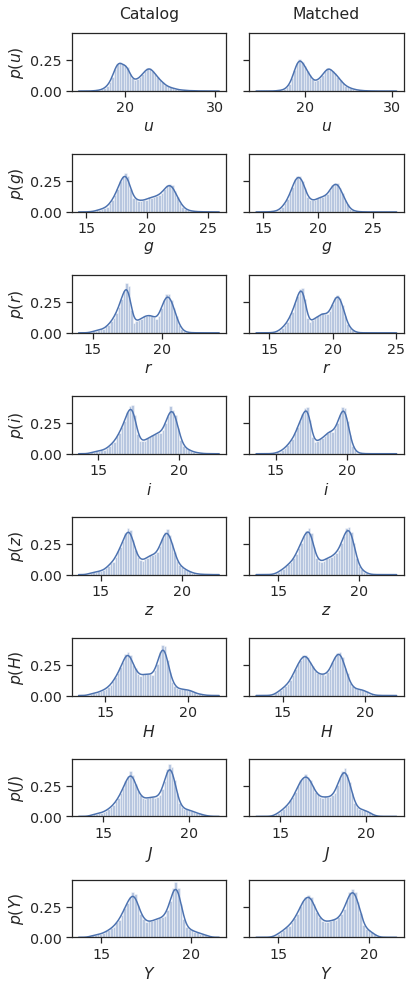

In [142]:
euclid_band_names = ['u', 'g', 'r', 'i', 'z', 'H', 'J', 'Y']

fig, axes = plt.subplots(nrows=len(euclid_bands), ncols=2, figsize=(6, 14), sharey=True)
for n, band in enumerate(euclid_bands):
    row = axes[n]
    sns.distplot(-2.5 * np.log10(df_clipped[band]), ax=row[0])
    sns.distplot(-2.5 * np.log10(paired_df[band]), ax=row[1])
    row[0].set_xlabel(f'${euclid_band_names[n]}$')
    row[1].set_xlabel(f'${euclid_band_names[n]}$')
    row[0].set_ylabel(f'$p({euclid_band_names[n]})$')
#     set the same limits
#     row[0].set_xlim(row[1].get_xlim())
# fontdict = {'fontweight': 'heavy'}
fontdict = None
pad = 15.
axes[0][0].set_title('Catalog', fontdict=fontdict, pad=pad)
axes[0][1].set_title('Matched', fontdict=fontdict, pad=pad)
fig.tight_layout()

In [143]:
fig.savefig('matched_catalog_mags.pdf')